In [1]:
%load_ext autoreload
%autoreload

import json
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import tqdm
import random
import torch
import sklearn
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
import inlp, inlp_dataset_handler, inlp_linear_model
import copy

In [2]:
with open('tweets.above-120.jsonl', "r", encoding = "utf-8") as f:
  lines = f.readlines()

all_tweets = []

for line in tqdm_notebook(lines[:]):
    d = json.loads(line)
    text = d["text"]
    lang = d["lang"]
    if lang is not None and "http" not in text and "@" not in text:
        
        all_tweets.append({"text": text.replace("\n", ".").lower(), "lang": lang})

/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [19]:
data = []
n = 1250

langs = ["en", "ar", "es", "pt", "it", "fr", "in", "hi", "de", "ru", "nl", "ja", "th", "tl"]
langs = ["en", "es", "it", "pt", "ru", "hi", "de", "fr"]
for lang in langs:    
    lang_tweets = [d for d in all_tweets if d["lang"] == lang]
    print(lang, len(lang_tweets))
    for i in range(n):
        tweet = random.choice(lang_tweets)
        data.append({"lang": lang, "text": tweet["text"]})

en 44735
es 11434
it 730
pt 16348
ru 1128
hi 2703
de 489
fr 2235


In [18]:
from collections import Counter
all_langs = [d["lang"] for d in all_tweets]
counter = Counter(all_langs)
print(counter.most_common(100))

[('en', 44735), ('pt', 16348), ('es', 11434), ('ar', 6116), ('in', 5788), ('tr', 3822), ('hi', 2703), ('tl', 2495), ('fr', 2235), ('ja', 2128), ('th', 1138), ('ru', 1128), ('it', 730), ('und', 683), ('de', 489), ('ur', 482), ('ht', 467), ('fa', 366), ('nl', 340), ('cy', 238), ('ko', 200), ('pl', 188), ('ca', 164), ('fi', 154), ('iw', 150), ('sv', 138), ('et', 89), ('ne', 75), ('da', 73), ('el', 68), ('mr', 68), ('ta', 65), ('cs', 65), ('uk', 64), ('zh', 51), ('bn', 39), ('ro', 35), ('ml', 35), ('hu', 27), ('lv', 27), ('sl', 27), ('no', 25), ('sr', 23), ('te', 22), ('kn', 21), ('vi', 15), ('si', 12), ('or', 11), ('ps', 10), ('is', 9), ('bg', 8), ('lt', 8), ('ckb', 8), ('eu', 6), ('gu', 4), ('sd', 3), ('pa', 3), ('my', 2), ('dv', 2), ('am', 2)]


## Run BERT

In [5]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-base-multilingual-uncased", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        self.model = BertModel.from_pretrained('bert-base-multilingual-uncased', config = config)

        #config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        #self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
        
        #config = AlbertConfig.from_pretrained("albert-xlarge-v2", output_hidden_states=True)
        #self.tokenizer = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
        #self.model = AlbertModel.from_pretrained("albert-xlarge-v2", config = config)
        #config = RobertaConfig.from_pretrained("roberta-large", output_hidden_states=True)
        #self.tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        #self.model = RobertaModel.from_pretrained('roberta-large', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str], capitalize = False) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        if capitalize:
            
            w = list(original_sentence[0])
            w[0] = w[0].upper()
            
            original_sentence[0] = "".join(w)
            
        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok)
        
        
        
def collect_bert_states(bert, data: List[Tuple], layers: List[int], strategy = "mean"):
    
        for i,d in tqdm.notebook.tqdm(enumerate(data), total = len(data)):

            text = d["text"]
            sent = " ".join(text)
            preds, orig2tok = bert.encode(sent, layers = layers)
        
            if strategy == "sum":
                states = np.sum(preds, axis = 0)
            elif strategy == "cls":
                states = preds[0]
            elif strategy == "rand-word":
                states = preds[random.choice(range(len(preds)))]
            data[i]["vec"] = states
    
        return data

In [6]:
bert = BertEncoder(device = "cpu")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/shauli/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.c7892120c5a9b21e515abc904e398dbabddf9510b122f659063cbf361fe16868
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "mode

In [7]:
data_with_states = collect_bert_states(bert, copy.deepcopy(data), layers = [1], strategy = "rand-word")

In [11]:
import pickle

with open("data_with_bert-large_states.pickle", "wb") as f:
    
    pickle.dump(data_with_states, f)

## TSNE by language

In [12]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "green", "orange", "black", "grey", "red", "purple", "pink", "brown", "cyan", "magenta", "gold", "brown"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        plt.scatter(vecs_2d[labels == label, 0], vecs_2d[labels == label, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha = 0.3)
  plt.legend()
  

  plt.title(title)

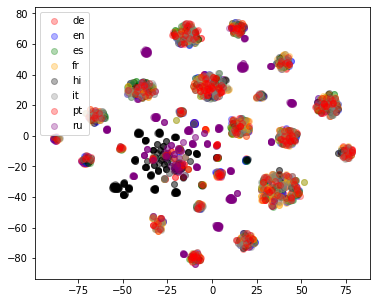

In [14]:
random.shuffle(data_with_states)
vecs = np.array([d["vec"] for d in data_with_states][:])
labels_lang = np.array([d["lang"] for d in data_with_states][:])
tsne(vecs[:3000], labels_lang[:3000])

## Classify language

In [15]:
l = int(len(vecs) * 0.9)
x_train_cls, x_dev_cls = vecs[:l], vecs[l:]
y_train_cls, y_dev_cls = labels_lang[:l], labels_lang[l:]
model = SGDClassifier(max_iter = 1000, alpha = 0.1)
model.fit(x_train_cls, y_train_cls)
print(model.score(x_dev_cls, y_dev_cls))

0.725


In [16]:
lgs = [d["lang"] for d in data_with_states]
set(lgs)

{'de', 'en', 'es', 'fr', 'hi', 'it', 'pt', 'ru'}

## Create dataset for INLP

In [28]:
num_examples_per_language = 1250
vecs1, vecs2, labels = [], [], []
for lang in langs:
    print(lang)
    relevant = [d for d in data_with_states if d["lang"] == lang]
    rest = [d for d in data_with_states if d["lang"] != lang]
    for i in range(num_examples_per_language):
        positive_pair = random.choice(relevant)["vec"], random.choice(relevant)["vec"]
        negative_pair = random.choice(relevant)["vec"], random.choice(rest)["vec"]
        
        # positive
        
        vecs1.append(positive_pair[0])
        vecs2.append(positive_pair[1])
        labels.append(1)
        
        # negative 
        vecs1.append(negative_pair[0])
        vecs2.append(negative_pair[1])
        labels.append(0)

vecs1, vecs2, labels = sklearn.utils.shuffle(vecs1, vecs2, labels)
vecs1 = np.array(vecs1)
vecs2 = np.array(vecs2)
labels = np.array(labels)
print(vecs1.shape, vecs2.shape, labels.shape)
l = int(len(vecs1) * 0.9)
x_train1, x_dev1 = vecs1[:l], vecs1[l:]
x_train2, x_dev2 = vecs2[:l], vecs2[l:]
y_train, y_dev = labels[:l], labels[l:]

concat_train = np.concatenate([x_train1, x_train2], axis = 1)
concat_dev = np.concatenate([x_dev1, x_dev2], axis = 1)
model = SGDClassifier(max_iter = 1000, alpha = 0.1)
model.fit(concat_train, y_train)
print(model.score(concat_dev, y_dev))

en
es
it
pt
ru
hi
de
fr
(20000, 768) (20000, 768) (20000,)
0.512


## INLP data preparation

In [30]:
inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 25, "input_dim": 768, "hidden_dim": 32, "batch_size": 64, "verbose": False, "device": "cpu",
         "compare_by": "dot_product", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = False)

In [35]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 1, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:
         Name               Type Params
0          l1             Linear   24 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  
/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:314: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)
/home/shauli/anaconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:144: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,val_acc,avg_val_loss
  RuntimeWarning)
iteration: 0, accuracy: 0.67529296875: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


In [32]:
v_rowspace = []
for w in Ws:
        
    w_norm = w/np.linalg.norm(w)
    v_rowspace.append(w_norm.dot(vecs.T))
    
v_rowspace = np.array(v_rowspace)
print(v_rowspace.shape)

(10, 32, 10000)


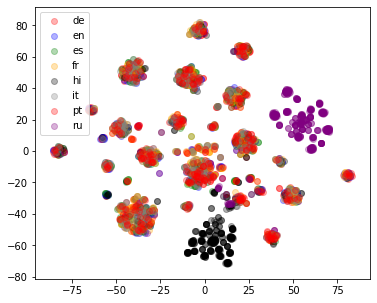

In [36]:
P_rowspace = np.eye(P.shape[0]) - P
tsne(P_rowspace.dot(vecs.T).T[:3000], labels_lang[:3000])

## Classification INLP

In [37]:
inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train_cls, y_train_cls, x_dev_cls, y_dev_cls, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False, "max_iter": 5000})
inlp_model_handler = inlp_linear_model.SKlearnClassifier(SGDClassifier, {"max_iter": 10000, "alpha": 0.1, "n_iter_no_change": 10})

In [39]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 2, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)


iteration: 1, accuracy: 0.4: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


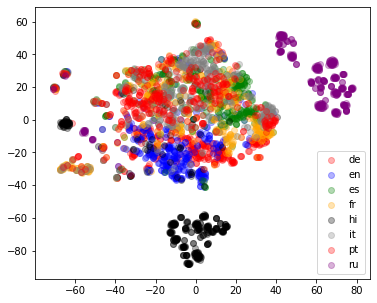

In [41]:
P_rowspace = np.eye(P.shape[0]) - P
tsne(P_rowspace.dot(vecs.T).T[:3000], labels_lang[:3000])